## This notebook is used to preprocess data and transform into an appropriate format for an LSTM

In [11]:
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
import pandas
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np

Create a mapping to transform the dataset into columns per sensor

In [12]:
replacement_mapping_dict = {
            "M01" : 0,
            "M02" : 1,
            "M03" : 2,
            "M04" : 3,
            "M05" : 4,
            "M06" : 5,
            "M07" : 6,
            "M08" : 7,
            "M09" : 8,
            "M10" : 9,
            "M11" : 10,
            "M12" : 11,
            "M13" : 12,
            "M14" : 13,
            "M15" : 14,
            "M16" : 15,
            "M17" : 16,
            "M18" : 17,
            "M19" : 18,
            "M20" : 19,
            "M21" : 20,
            "M22" : 21,
            "M23" : 22,
            "M24" : 23,
            "M25" : 24,
            "M26" : 25,
            "I01" : 26,
            "I02" : 27,
            "I03" : 28,
            "I04" : 29,
            "I05" : 30,
            "I06" : 31,
            "I07" : 32,
            "I08" : 33,
            "D01" : 34,
            "AD1-A" : 35,
            "AD1-B" : 36,
            "AD1-C" : 37,
        }

Load the dataset.

In [13]:
dataset = read_csv('datasets/adlnormal/data.csv')
# for now exclude asterisk and EO1
dataset = dataset[dataset["SensorId"] != "E01"]
dataset = dataset[dataset["SensorId"] != "asterisk"]

# replace ON/OFF for light sensors, ABSENT/PRESENT for bowls/food and OPEN/CLOSE for door sensors
dataset["SensorValue"] = dataset["SensorValue"].replace({"ON" : 1.0, "OFF" : 0.0})
dataset["SensorValue"] = dataset["SensorValue"].replace({"ABSENT" : 1.0, "PRESENT" : 0.0})
dataset["SensorValue"] = dataset["SensorValue"].replace({"OPEN" : 1.0, "CLOSE" : 0.0})
# transform sensorids from text into numbers to make life easier
dataset["SensorId"].replace(replacement_mapping_dict, inplace=True)
# drop the event labelling as we aren't predicting activities
dataset.drop('Event', axis=1, inplace=True)

Now, create a transformed data set where the columns represent the various sensor values.
Furthermore, collate the data into 10 second segments to reduce sparcity. 
To avoid empty fields, oscillations of on/off values will be simply reported as 1 - representing activation

In [14]:
data = []
current_date = dataset.iloc[0]["Date"]
first_row_time = dataset.iloc[0]["Time"].split(".")
first_row_time = first_row_time[:1]
current_time = ((datetime.strptime(first_row_time[0], "%H:%M:%S").second // 10 ) + 1 ) * 10 
if (current_time > 50):
    current_time = 60
sensor_vals = [0.0] * 38
first_time = datetime.strptime(first_row_time[0], "%H:%M:%S")
date_and_time = []
date_and_time.append(current_date)
date_and_time.append(str(first_time.hour) + ":" + str(first_time.minute) + "." + str(current_time))
for i, row in dataset.iterrows():
    date = row["Date"]
    time = row["Time"].split(".")
    time = time[:1]
    time = datetime.strptime(time[0], "%H:%M:%S")
    if ((current_time == 60 and time.second < current_time ) or time.second >= current_time):
        date_and_time.extend(sensor_vals)
        data.append(date_and_time)
        date_and_time = []
        current_date = date
        if (current_time == 60):
            current_time = 10
        else:
            current_time += 10
        sensor_vals = [0.0] * 38
        if (sensor_vals[int(row["SensorId"])] != 1.0):
            sensor_vals[int(row["SensorId"])] = row["SensorValue"]
        date_and_time.append(row["Date"])
        new_time = str(time.hour) + ":" + str(time.minute) + "." + str(current_time)
        date_and_time.append(new_time)
    if (sensor_vals[int(row["SensorId"])] != 1.0):
        sensor_vals[int(row["SensorId"])] = row["SensorValue"]
columns = [i for i in range (0,38)]
final_columns = ["Date", "Time"]
final_columns.extend(columns)
new_data = pandas.DataFrame.from_records(data, columns=final_columns)      
print(new_data.head)

<bound method NDFrame.head of             Date      Time    0    1    2    3    4    5    6    7  ...   28  \
0     2008-02-27  12:43.30  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  ...  0.0   
1     2008-02-27  12:43.40  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2     2008-02-27  12:43.50  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
3     2008-02-27  12:44.60  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
4     2008-02-27  12:45.10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
...          ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1910  2008-05-21  16:46.50  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1911  2008-05-21  16:46.60  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1912  2008-05-21  16:46.10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1913  2008-05-21  16:46.20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1914  2008-05-21  16:46.30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

       29

Plot the data to identify useless fields

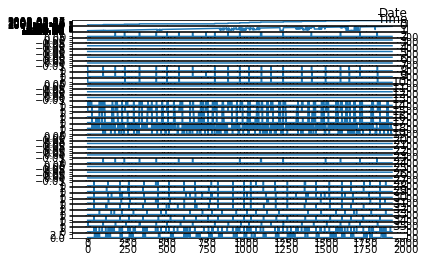

Irrelevant columns are:  [1, 2, 3, 4, 5, 9, 10, 11, 18, 19, 20, 21, 23, 24, 25]


In [15]:
values = new_data.values
groups = []
empty_columns = []
for i in range (0,38):
    groups.append(i)
    if ((new_data[i] == new_data[i][0]).all()):
        empty_columns.append(i)
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(new_data.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()
print("Irrelevant columns are: ", empty_columns)


Remove empty columns from the data and plot resulting traces

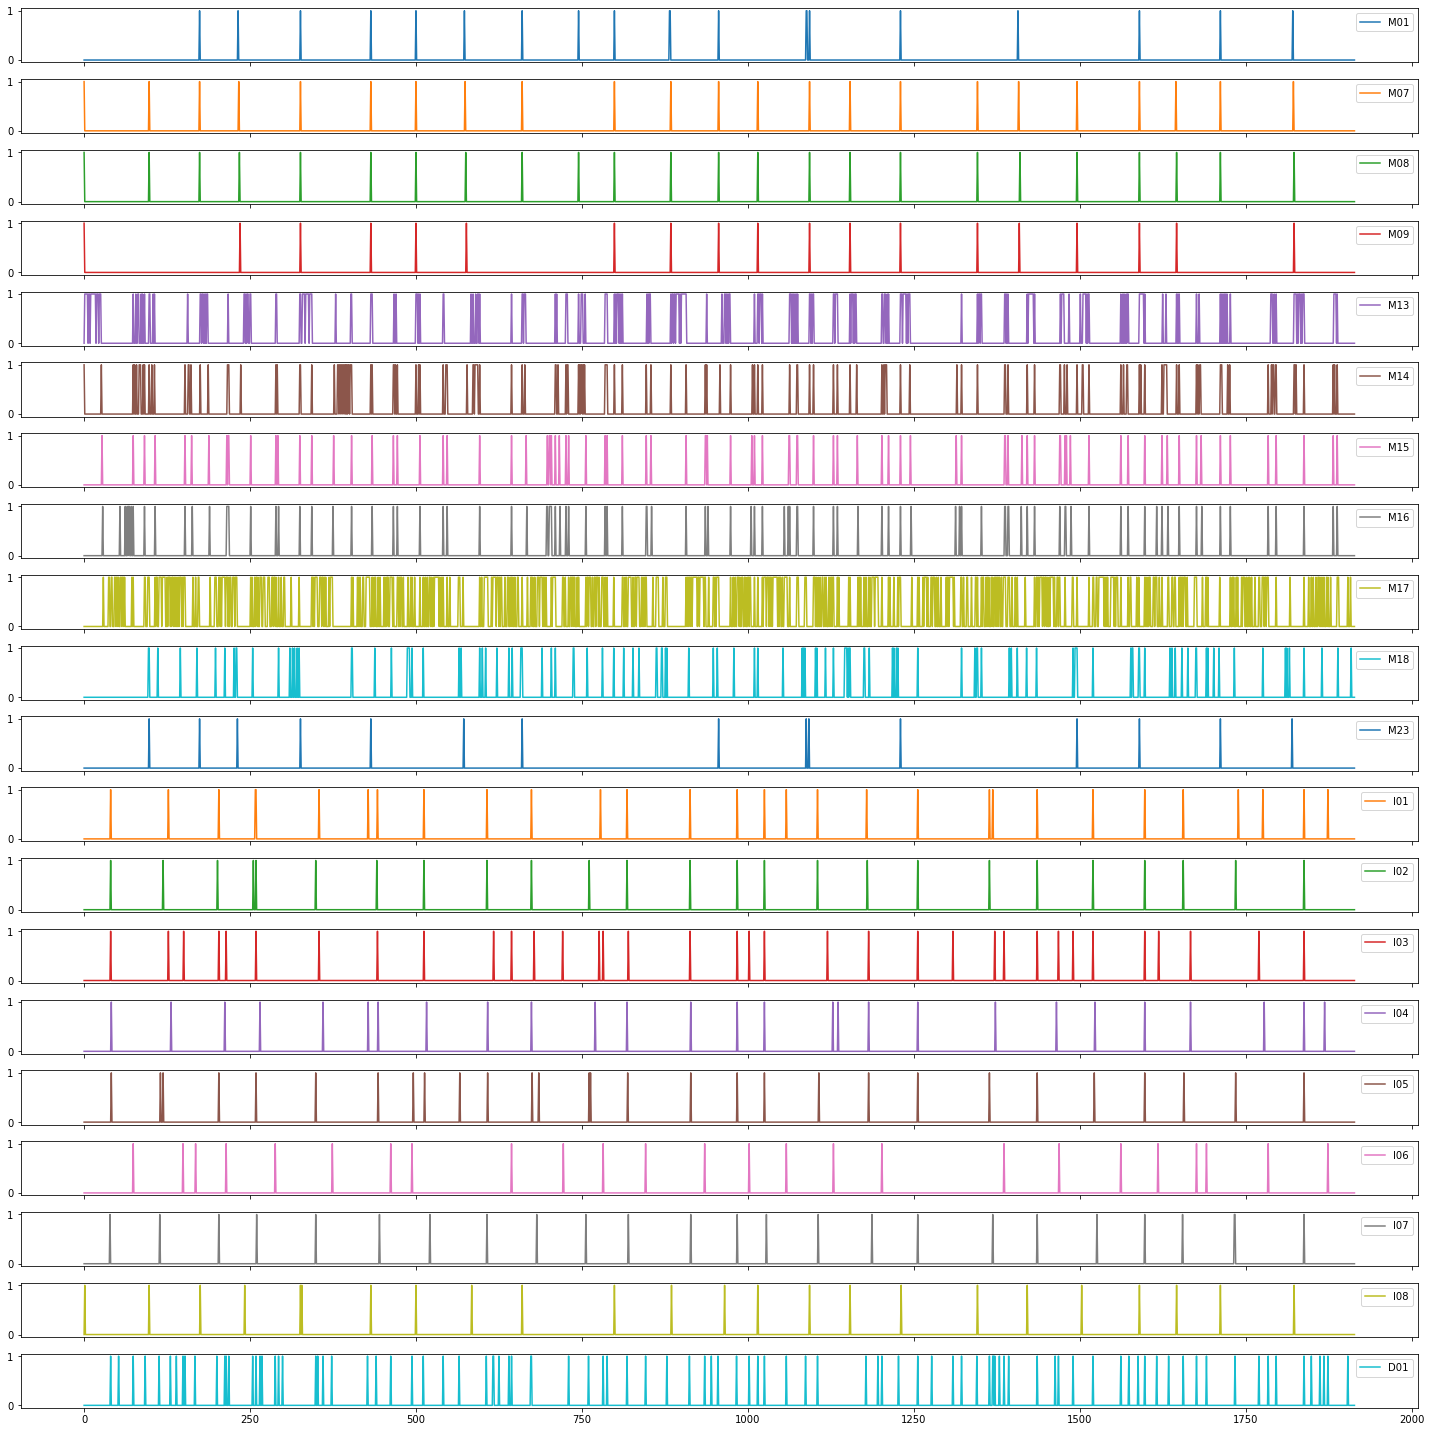

In [16]:
new_data.drop(empty_columns, axis=1, inplace=True)
reversed_mapping = {y: x for x, y in replacement_mapping_dict.items()}
changed_legend = new_data.rename(columns = reversed_mapping)
for column in empty_columns:
    reversed_mapping.pop(column)

changed_legend.plot(subplots=True, figsize=(20,20))
pyplot.tight_layout()
pyplot.savefig("plots/CleanedData.png", format="png", dpi=1200)

now create a scatter plot of the data at each time step

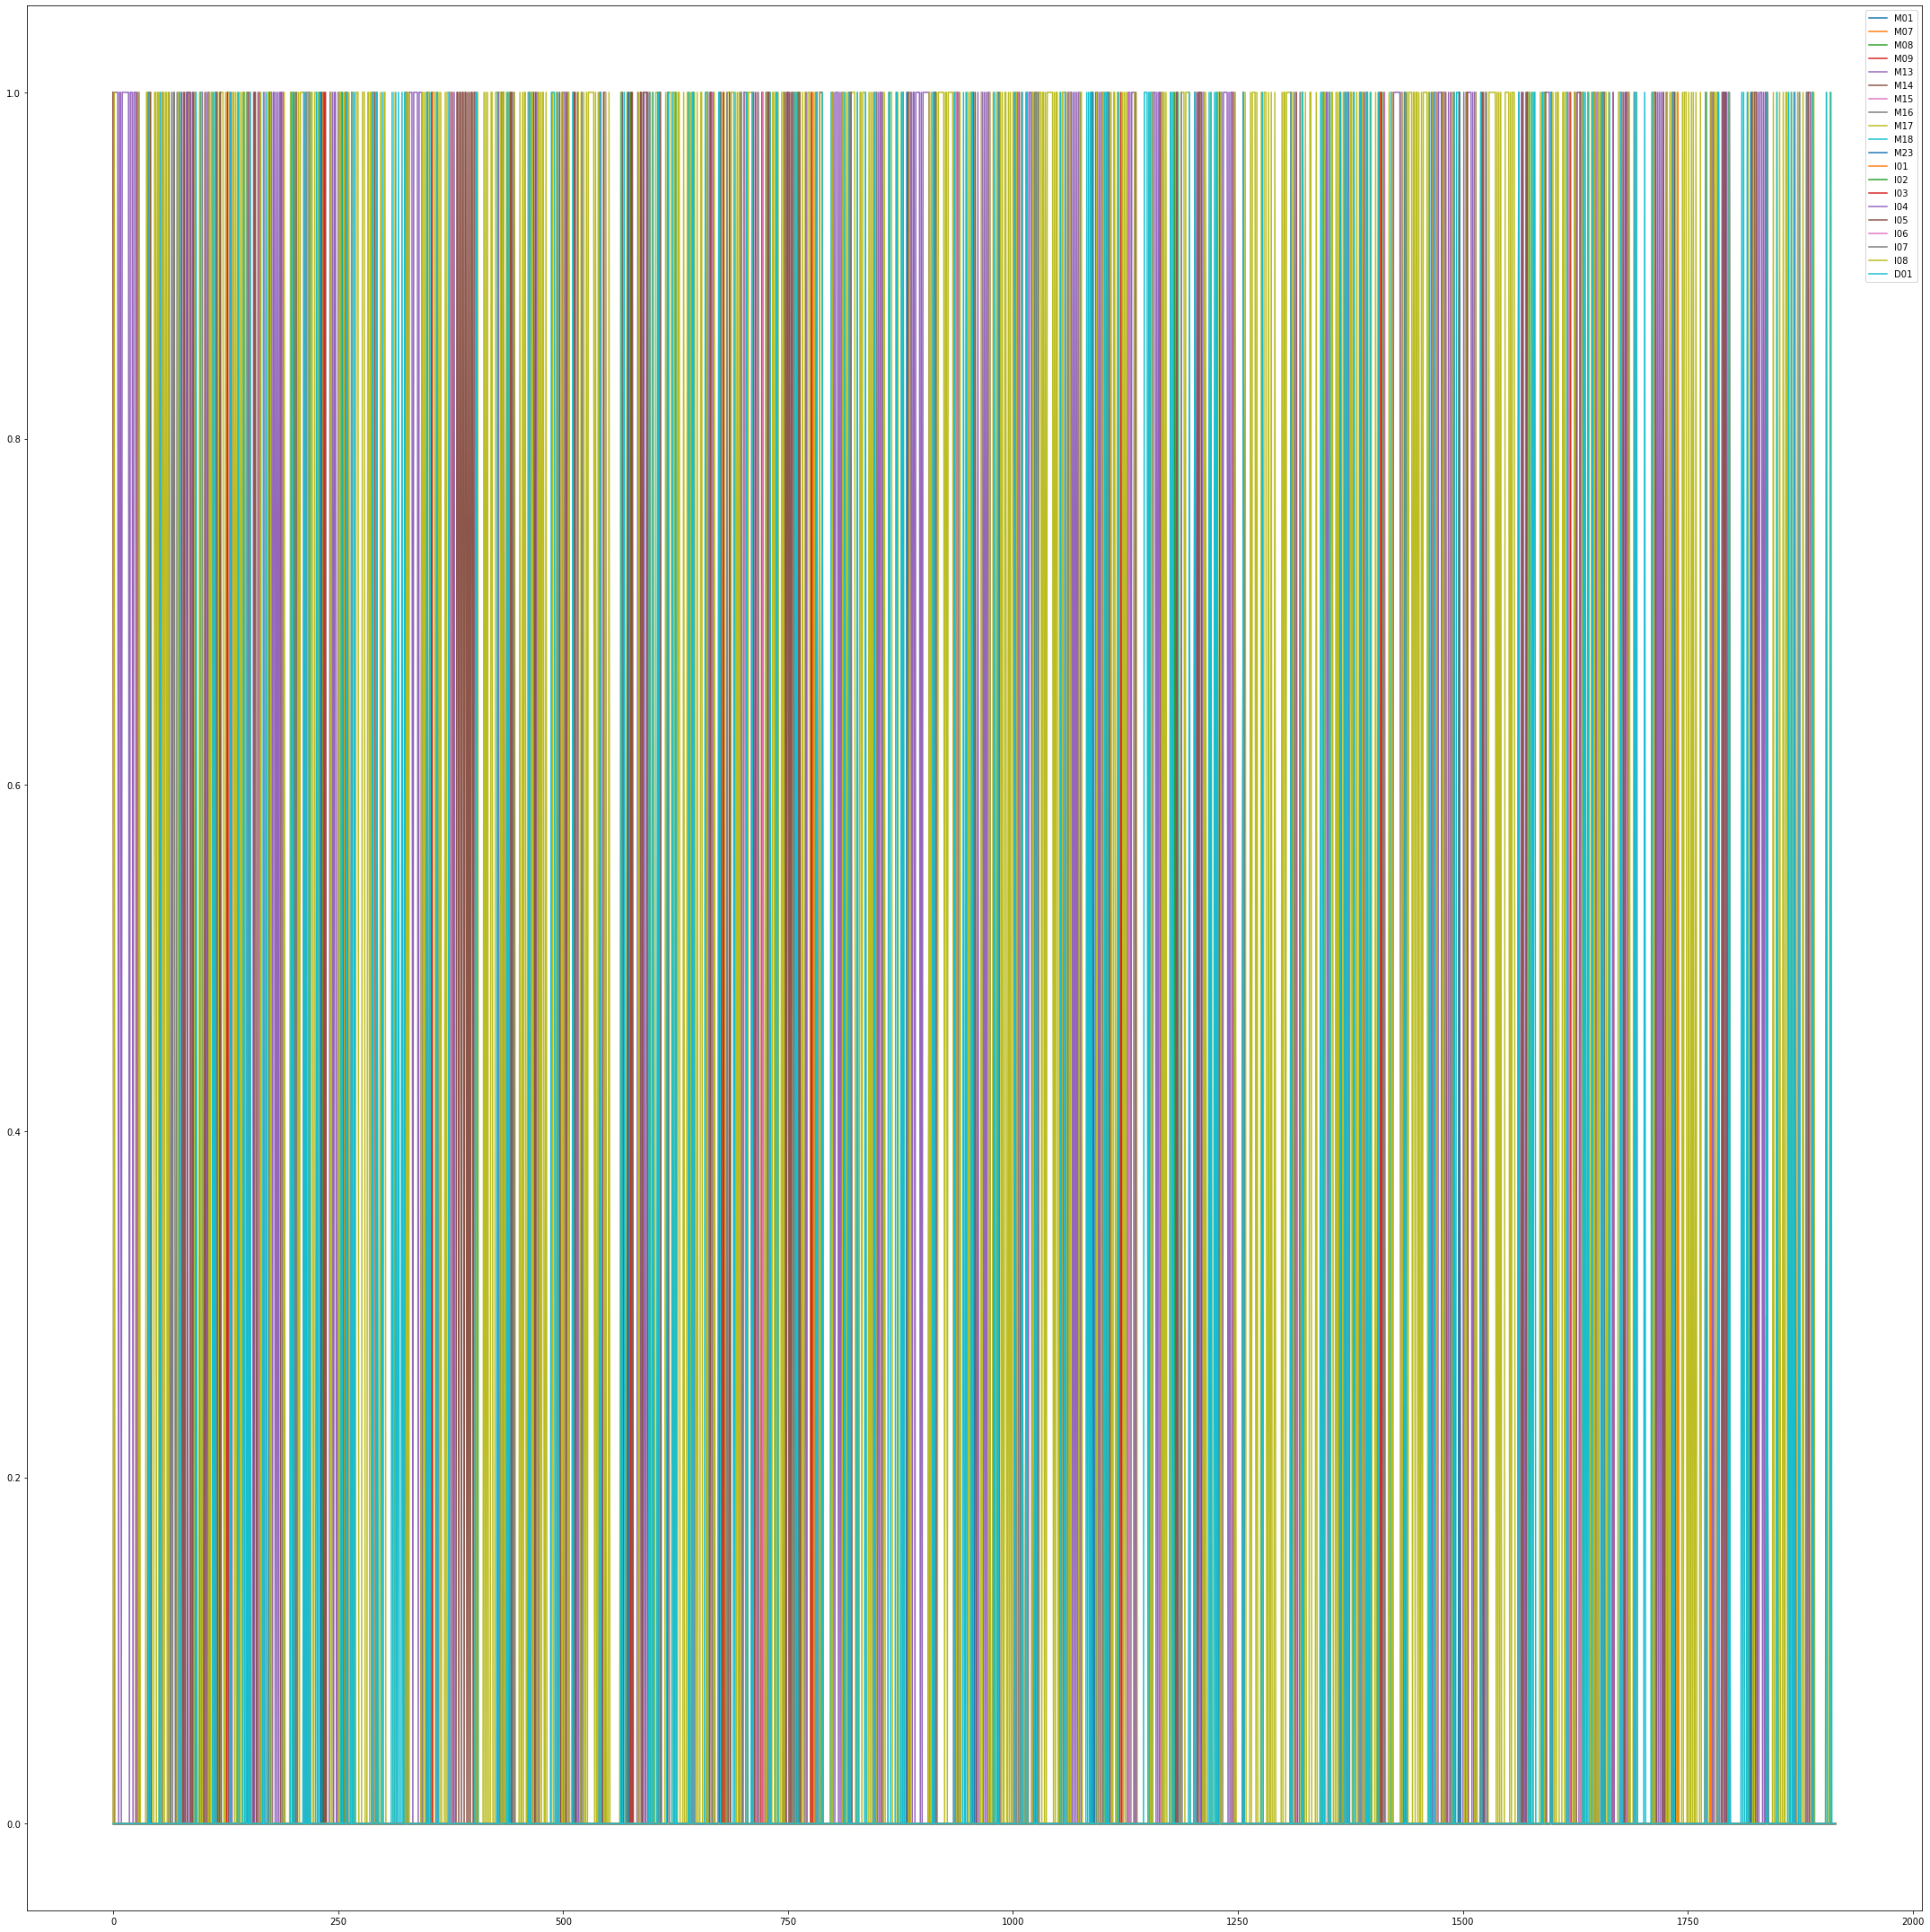

In [34]:
changed_legend.plot(figsize=(30,30))
pyplot.tight_layout()
pyplot.savefig("plots/idk.png", format="png", dpi=1200)

Now need to transform the data into a sequence form so that we have predicted labels for each row of data

In [17]:
df = changed_legend.copy()
df.drop(columns=["Date", "Time"], inplace=True)
n_vars = len(df.columns)
cols, names = list(), list()
# input sequence (t-n, ... t-1)
for i in range(1, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
for i in range(0, 1):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
agg = concat(cols, axis=1)
agg.columns = names
# drop rows with NaN values
agg.dropna(inplace=True)

Now we need to separate into test and train data

In [18]:
values = agg.values
train_split = int(0.8 * len(values))

train = values[:train_split, :]
test = values[train_split:, :]


train_x, train_y = train[:, :23], train[:, 23:]
test_x, test_y = test[:, :23], test[:, 23:]
train_x = np.asarray(train_x).astype(np.float32)
train_y = np.asarray(train_y).astype(np.float32)
test_y = np.asarray(test_y).astype(np.float32)
test_x = np.asarray(test_x).astype(np.float32)
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))


Now create the network

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-19 13:12:16.013462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-19 13:12:16.013629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2022-07-19 13:12:16.808678: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-19 13:12:17.452079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-19 13:12:17.641998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-19 13:12:19.214443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 - 3s - loss: 0.0852 - val_loss: 0.0993 - 3s/epoch - 157ms/step
Epoch 2/100


2022-07-19 13:12:20.158996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-19 13:12:20.217427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 - 0s - loss: 0.0718 - val_loss: 0.0811 - 199ms/epoch - 9ms/step
Epoch 3/100
22/22 - 0s - loss: 0.0676 - val_loss: 0.0744 - 187ms/epoch - 8ms/step
Epoch 4/100
22/22 - 0s - loss: 0.0666 - val_loss: 0.0730 - 184ms/epoch - 8ms/step
Epoch 5/100
22/22 - 0s - loss: 0.0661 - val_loss: 0.0727 - 186ms/epoch - 8ms/step
Epoch 6/100
22/22 - 0s - loss: 0.0658 - val_loss: 0.0725 - 191ms/epoch - 9ms/step
Epoch 7/100
22/22 - 0s - loss: 0.0656 - val_loss: 0.0723 - 185ms/epoch - 8ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0654 - val_loss: 0.0722 - 188ms/epoch - 9ms/step
Epoch 9/100
22/22 - 0s - loss: 0.0653 - val_loss: 0.0721 - 188ms/epoch - 9ms/step
Epoch 10/100
22/22 - 0s - loss: 0.0652 - val_loss: 0.0719 - 188ms/epoch - 9ms/step
Epoch 11/100
22/22 - 0s - loss: 0.0651 - val_loss: 0.0718 - 186ms/epoch - 8ms/step
Epoch 12/100
22/22 - 0s - loss: 0.0650 - val_loss: 0.0718 - 195ms/epoch - 9ms/step
Epoch 13/100
22/22 - 0s - loss: 0.0649 - val_loss: 0.0717 - 203ms/epoch - 9ms/step
Epoch 14/100
22/22 - 0s 

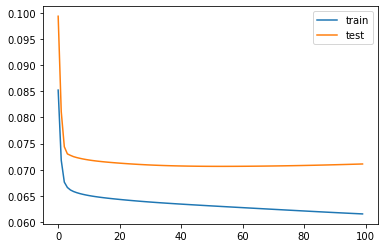

In [19]:
# design network
model = Sequential()
model.add(LSTM(300, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(23))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(test_x, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Now test the model

In [20]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], 23))
print(yhat)
# # calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)


 1/12 [=>............................] - ETA: 3s

2022-07-19 13:12:40.481085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-19 13:12:40.537001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 4ms/step
[[-7.0160273e-03  2.8343871e-04  4.7252513e-03 ...  2.0002885e+00
   1.1023123e-02  1.8586801e-02]
 [ 1.1883158e-02  5.9273830e-03  8.0984533e-03 ...  4.0868649e-01
   2.7966030e-02  1.5570600e-02]
 [ 1.1883158e-02  5.9273830e-03  8.0984533e-03 ...  4.0868649e-01
   2.7966030e-02  1.5570600e-02]
 ...
 [ 1.0586353e-02 -2.4883077e-05  7.9497192e-03 ...  4.8961289e-02
   2.0345441e-01  9.8804822e-03]
 [ 1.0753013e-02 -1.2535956e-03  7.1234051e-03 ...  1.7386768e-02
   2.2719514e-01  8.7683955e-03]
 [ 5.2743182e-03  8.5208146e-03  9.4642509e-03 ...  1.9082184e-01
   3.7858661e-02  9.9861026e-02]]
Test RMSE: 0.267


In [35]:
# Try generating some anomalous data
# One idea is to just scale data to be bigger than 1, in theory this is an anomaly but isn't really in the expected range of input...
# https://github.com/tirthajyoti/Synthetic-data-gen/blob/master/Notebooks/Time%20series%20synthesis%20with%20anomaly.ipynb
anomaly_frac = 0.2
one_sided = False
new_arr = agg.copy()
arr_min = new_arr.min()
arr_max = new_arr.max()
no_anomalies = int(new_arr.size * anomaly_frac)
idx_list = np.random.choice(a=new_arr.size , size=no_anomalies, replace=False)
for idx in idx_list:
    if one_sided:
        new_arr[idx] = self.loc + np.random.uniform(
            low=arr_min, high=anomaly_scale * (arr_max - arr_min)
        )
    else:
        new_arr[idx] = self.loc + np.random.uniform(
            low=-anomaly_scale * (arr_max - arr_min),
            high=anomaly_scale * (arr_max - arr_min),
        )
self.anomalized_data = new_arr
self._anomaly_flag_ = True

if return_df:
    df = pd.DataFrame(
        {"time": self.time_arr, "anomaly_data": self.anomalized_data}
    )
    return df
else:
    return self.anomalized_data

var1(t-1)     0.0
var2(t-1)     0.0
var3(t-1)     0.0
var4(t-1)     0.0
var5(t-1)     0.0
var6(t-1)     0.0
var7(t-1)     0.0
var8(t-1)     0.0
var9(t-1)     0.0
var10(t-1)    0.0
var11(t-1)    0.0
var12(t-1)    0.0
var13(t-1)    0.0
var14(t-1)    0.0
var15(t-1)    0.0
var16(t-1)    0.0
var17(t-1)    0.0
var18(t-1)    0.0
var19(t-1)    0.0
var20(t-1)    0.0
var1(t)       0.0
var2(t)       0.0
var3(t)       0.0
var4(t)       0.0
var5(t)       0.0
var6(t)       0.0
var7(t)       0.0
var8(t)       0.0
var9(t)       0.0
var10(t)      0.0
var11(t)      0.0
var12(t)      0.0
var13(t)      0.0
var14(t)      0.0
var15(t)      0.0
var16(t)      0.0
var17(t)      0.0
var18(t)      0.0
var19(t)      0.0
var20(t)      0.0
dtype: float64


/var/folders/cy/ykpjhkhn2q5f0x_yjxc7ymfr0000gn/T/ipykernel_38262/928903321.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  arr_min = new_arr.min()
/var/folders/cy/ykpjhkhn2q5f0x_yjxc7ymfr0000gn/T/ipykernel_38262/928903321.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  arr_max = new_arr.max()


NameError: name 'self' is not defined